# Exploration Lesson

What is it?
- understand what features are driving the outcome
- try to find patterns in the data

Why do we care? 
- gain insights on our data 
- use knowledge to determine modeling
- if we see patterns, maybe we can build clusters

## Scenario
We would like to be able to use attributes of mall customers to estimate their spending score. In doing so, we can target those customers that are likely to be most profitable for us. Our target variable is spending_score. Currently the only customer data we have available to use in this project is age, annual_income and gender. It is possible we may not have enough information to build a valuable model. If not, maybe we could do some unsupervised learning, and find clusters of similar customers using all of the variables (including spending_score) and that could help us with a starting point for our targeted marketing.

In [7]:
#standard ds
import pandas as pd
import numpy as np

#viz and stats
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

#splits, scale
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#my env file
from env import get_db_url

## Acquire

In [8]:
#get my data
df = pd.read_sql('SELECT * FROM customers;', get_db_url('mall_customers'))
df = df.set_index('customer_id')

#see it
df.head()

,gender,age,annual_income,spending_score
customer_id,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          200 non-null    object
 1   age             200 non-null    int64 
 2   annual_income   200 non-null    int64 
 3   spending_score  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


## Prepare

In [10]:
def train_validate_test_split(df, target, seed=123):
    '''
    accepts dataframe and splits the data into train, validate and test 
    '''
    train_validate, test = train_test_split(df, test_size=0.2, random_state=seed)
    
    train, validate = train_test_split(train_validate, test_size=0.25, random_state=seed)
    return train, validate, test

In [11]:
def scale_my_data(train, validate, test):
    '''
    scale my data using minmaxscaler and add it back to my input datasets
    '''
    scaler = MinMaxScaler()
    scaler.fit(train[['age', 'annual_income']])
    
    X_train_scaled = scaler.transform(train[['age', 'annual_income']])
    X_validate_scaled = scaler.transform(validate[['age', 'annual_income']])
    X_test_scaled = scaler.transform(test[['age', 'annual_income']])

    train[['age_scaled', 'annual_income_scaled']] = X_train_scaled
    validate[['age_scaled', 'annual_income_scaled']] = X_validate_scaled
    test[['age_scaled', 'annual_income_scaled']] = X_test_scaled
    return train, validate, test

In [12]:
def prep_mall(df):
    '''
    dummy var for gender into is_male
    split on target of 'spending_score'
    scale age and annual income. 
    '''
    df['is_male'] = pd.get_dummies(df['gender'], drop_first=True)['Male']
    train, validate, test = train_validate_test_split(df, target='spending_score', seed=1349)
    train, validate, test = scale_my_data(train, validate, test)
    
    print(f'df: {df.shape}')
    print()
    print(f'train: {train.shape}')
    print(f'validate: {validate.shape}')
    print(f'test: {test.shape}')
    return df, train, validate, test

In [13]:
#prep my data!
df, train, validate, test = prep_mall(df)

df: (200, 5)

train: (120, 7)
validate: (40, 7)
test: (40, 7)


In [14]:
train.head()

,gender,age,annual_income,spending_score,is_male,age_scaled,annual_income_scaled
customer_id,,,,,,,
158,Female,30,78,78,0,0.230769,0.516393
14,Female,24,20,77,0,0.115385,0.040984
116,Female,19,65,50,0,0.019231,0.409836
69,Male,19,48,59,1,0.019231,0.270492
167,Male,42,86,20,1,0.461538,0.581967


## Explore

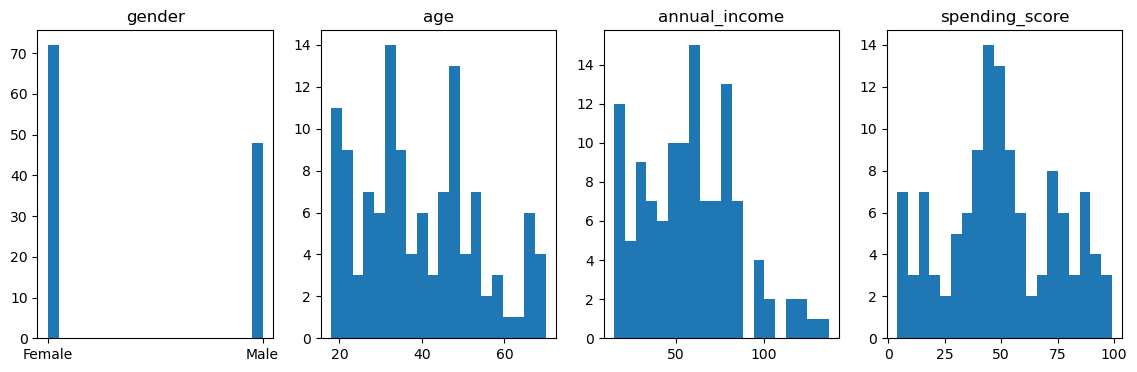

In [23]:
#distribution of all my variables
plt.figure(figsize=(14,4))

for i, col in enumerate(train.columns[:-3]):
    plt.subplot(1,len(train.columns[:-3]),i+1)
    plt.hist(train[col], bins=20)
    plt.title(col)

**Takeaways**
- in gender, we have less males than females
- age and annual_income are not normal, skewed to the right
- spending_score is the most normal

## If you don't know where to start, start with pairplot

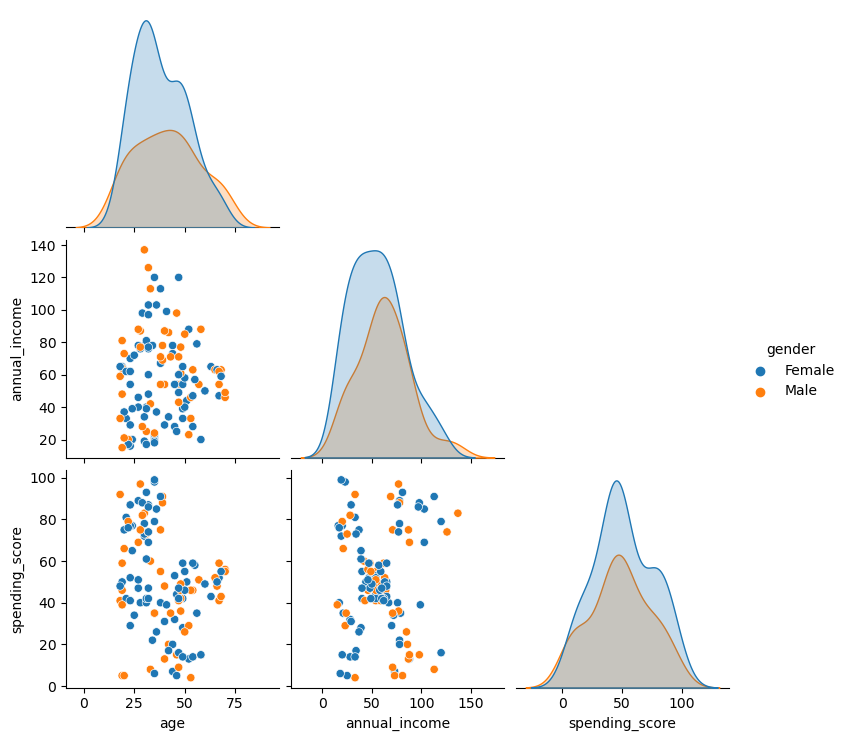

In [21]:
#only looking at my unprocessed data only
sns.pairplot(
            train[['gender', 'age', 'annual_income', 'spending_score']], 
    hue='gender',
             corner=True
            )
plt.show()

**Takeaways**
- annual_income and spending_score potentially has clusters
- gender doesn't populate on the pairplot 
- we set gender as a hue, and we don't see any relationships with gender

## Q. Does the spending score differ across gender?

In [22]:
train.shape

(120, 7)

what kind of variables do i have?
- gender: categorical
- spending_score: continuous

what types of plots can i use?
- barplot
- violin
- boxplot
- stripplot
- swarmplot
- histograms on top of each other


what type of stats test should i use? 
- mannwhitney

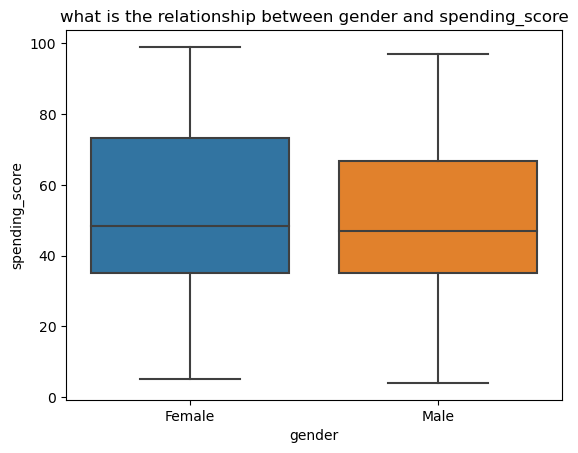

In [24]:
#visualize my variables
sns.boxplot(data=train, x='gender', y='spending_score')
plt.title('what is the relationship between gender and spending_score')
plt.show()

mann-whitley test
- $H_0$: there is no difference in spending scores between genders
- $H_a$: there is a difference in spending scores between genders

alpha = 0.05

In [25]:
#verify with stats
stats.mannwhitneyu(train[train.gender=='Male'].spending_score, 
                   train[train.gender=='Female'].spending_score)

MannwhitneyuResult(statistic=1636.0, pvalue=0.623938496454556)

result: my p-value is greater than alpha, fail to reject the null hypothesis, there we assume there is not a relationship between spending score and gender

**Takeaways**
-  gender doesnt affect spending score

## Q. Is there a relationship between spending score and annual income?


what kind of variables do i have?
- annual income: continuous
- spending score: continuosu

what types of plots can i use?
- scatter

what type of stats test should i use? 
- spearmans

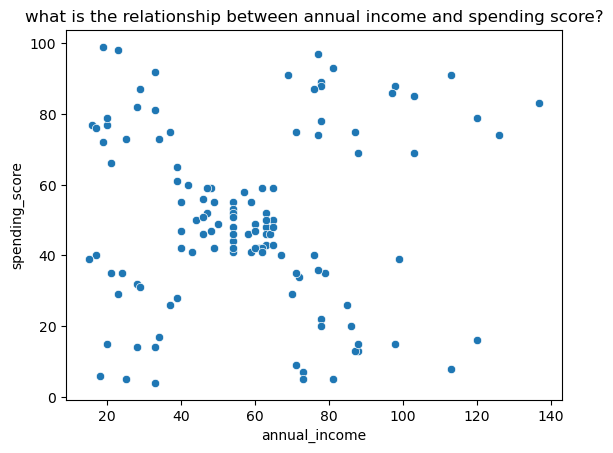

In [26]:
#visualize my variables
sns.scatterplot(data=train, x='annual_income', y='spending_score')
plt.title('what is the relationship between annual income and spending score?')
plt.show()

Spearman R
- $H_0$: there is no linear correlation between annual income and spending score
- $H_a$: there is linear correlation between annual income and spending score

In [27]:
#verify it with stats
stats.spearmanr(train.annual_income, train.spending_score)

SignificanceResult(statistic=-0.016298456034448447, pvalue=0.8597569266892506)

result: my p-value is greater than alpha, therefore, we fail to reject the null hypothesis

**Takeaways**
- there is not a linear relationship
- but i do see some kind of X shape, and it looks i might be able to make clusters!

## Q. Is there a relationship between age and spending score? 

In [29]:
train.head()

,gender,age,annual_income,spending_score,is_male,age_scaled,annual_income_scaled
customer_id,,,,,,,
158,Female,30,78,78,0,0.230769,0.516393
14,Female,24,20,77,0,0.115385,0.040984
116,Female,19,65,50,0,0.019231,0.409836
69,Male,19,48,59,1,0.019231,0.270492
167,Male,42,86,20,1,0.461538,0.581967


what kind of variables do i have?
- age: discrete --> we'll treat as continuous
- spending_score: continuous

what types of plots can i use?
- scatter

what type of stats test should i use? 
- spearmans

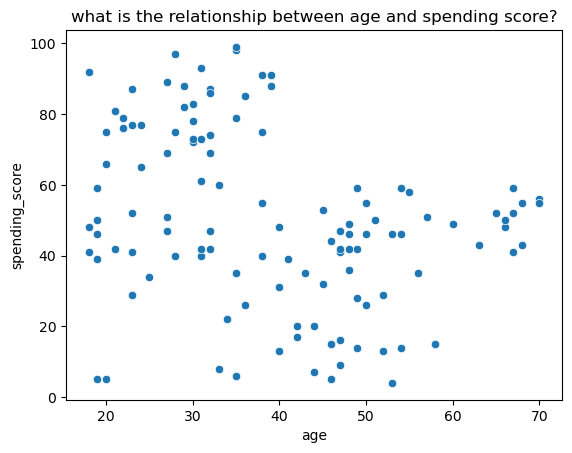

In [30]:
#visualize my variables
sns.scatterplot(data=train, x='age', y='spending_score', )
plt.title('what is the relationship between age and spending score?')
plt.show()

thoughts: something happens when you turn 40, the spending_score drops off

#### create a bin for age

In [31]:
#make new age_bin column
train['age_bins'] = pd.cut(
                    train.age, #column to bin
                    [0,40,80], #the bins including the starting and ending point
                    labels=['40_and_under', 'over_40'] #labels for my bins
                )

In [32]:
#look at it!
train.head()

,gender,age,annual_income,spending_score,is_male,age_scaled,annual_income_scaled,age_bins
customer_id,,,,,,,,
158,Female,30,78,78,0,0.230769,0.516393,40_and_under
14,Female,24,20,77,0,0.115385,0.040984,40_and_under
116,Female,19,65,50,0,0.019231,0.409836,40_and_under
69,Male,19,48,59,1,0.019231,0.270492,40_and_under
167,Male,42,86,20,1,0.461538,0.581967,over_40


In [33]:
#distribution
train.age_bins.value_counts()

40_and_under    68
over_40         52
Name: age_bins, dtype: int64

In [34]:
#type of new column
train.dtypes

gender                    object
age                        int64
annual_income              int64
spending_score             int64
is_male                    uint8
age_scaled               float64
annual_income_scaled     float64
age_bins                category
dtype: object

#### dive into my new variable

what kind of variables do i have?
- age_bins: categorical
- spending_score: continuous

what types of plots can i use?
- boxplots, barplot, etc

what type of stats test should i use? 
- comparing means tests
- ttest
- 2sample,2tail

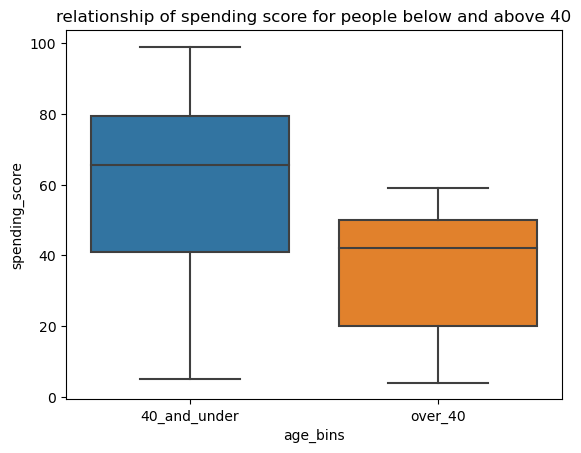

In [35]:
#visualize my variable
sns.boxplot(data=train, x='age_bins', y='spending_score')
plt.title('relationship of spending score for people below and above 40')
plt.show()

$H_0$: the variance are equal

$H_a$: the variance is not equal

alpha=0.5

In [36]:
#check for equal variances 
stats.levene(train.spending_score[train.age_bins == '40_and_under'],
             train.spending_score[train.age_bins == 'over_40'],)

LeveneResult(statistic=11.923559821448173, pvalue=0.0007703961737564596)

p-value is less than alpha, therefore, we reject the null hypothesis. so our variances are NOT equal

In [38]:
#verify with a stats test
stats.ttest_ind(train.spending_score[train.age_bins == '40_and_under'],
                train.spending_score[train.age_bins == 'over_40'],
                equal_var=False)

Ttest_indResult(statistic=5.989269901612585, pvalue=2.4418477390674727e-08)

result: p-value is less than alpha, therefore, we reject the null hypothesis

**Takeaways**
- there is a difference in spending scores when we group by 40 and over

## Q. If we control for age, does spending score differ across annual income?

what kind of variables do i have?
- age_bins: categorical
- annual_income: continuous 
- spending_score: continuous

what types of plots can i use?
- scatter + hue -- relpot
- scatter + col -- replot

what type of stats test should i use? 
- out of scope

In [39]:
#calculate my mean spending score
ss_mean = train.spending_score.mean()
ss_mean

50.05

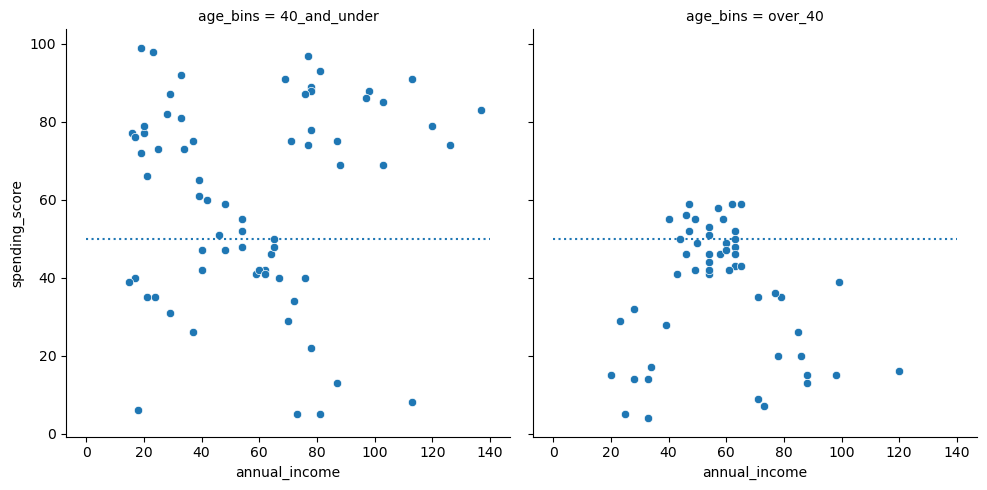

In [44]:
#visulize my variables
p = sns.relplot(data=train, 
                x='annual_income', 
                y='spending_score', 
                col='age_bins'
            # hue='age_bins'
               )

# plt.hlines(ss_mean,0,140)

#cycle through each axes-level plot to add overall mean line
for ax in p.axes.flat:
    ax.hlines(ss_mean,0,140, ls=':')

thoughts: over 40 is the same, under 40 is a little ambigous still

#### bin my under 40

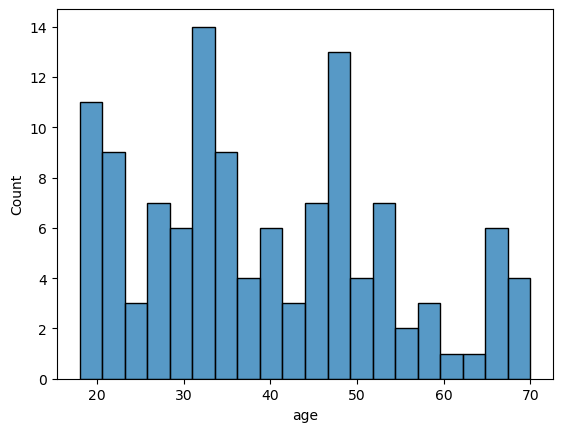

In [45]:
#see where to make my bin
sns.histplot(train.age, bins=20)
plt.show()

thoughts:

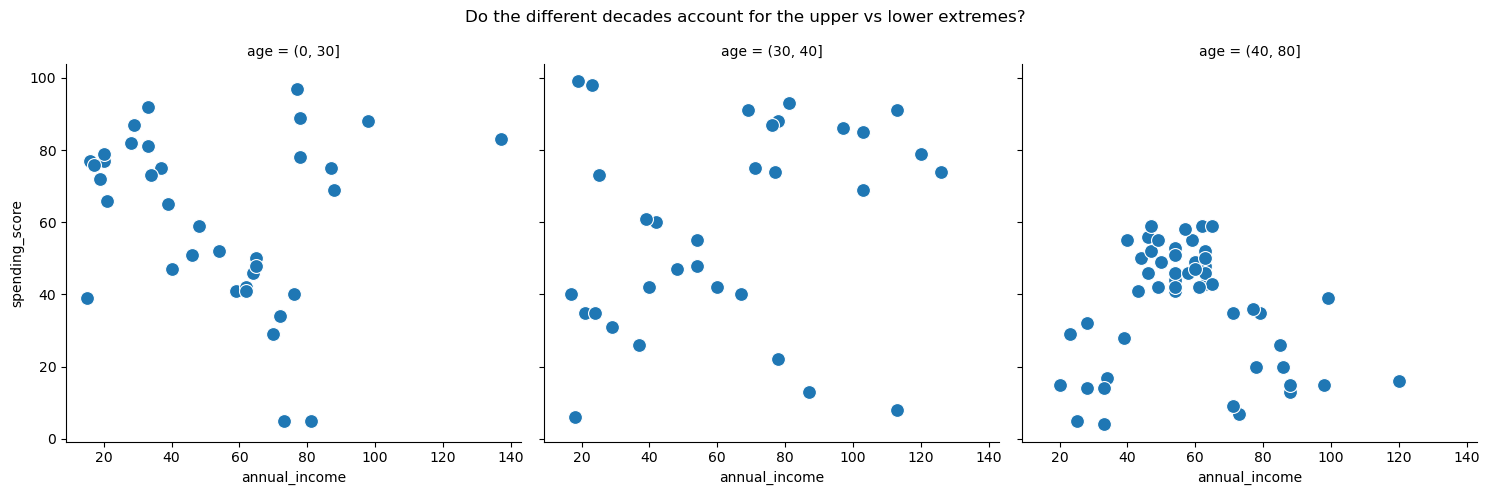

In [46]:
#visualize my variables
sns.relplot(data=train, 
            x='annual_income', 
            y='spending_score',
            s=100,
            col=pd.cut(train.age,[0,30,40,80]) #adding an additional bin
           )

plt.suptitle("Do the different decades account for the upper vs lower extremes?")
plt.tight_layout()
plt.show()

thoughts: looks like under 30 is making the least & spending the most, the middle one group is most scatter, and over 40 is still the same

#### how does gender affect them?

how do i add a fourth category to my plots?
- add a hue!

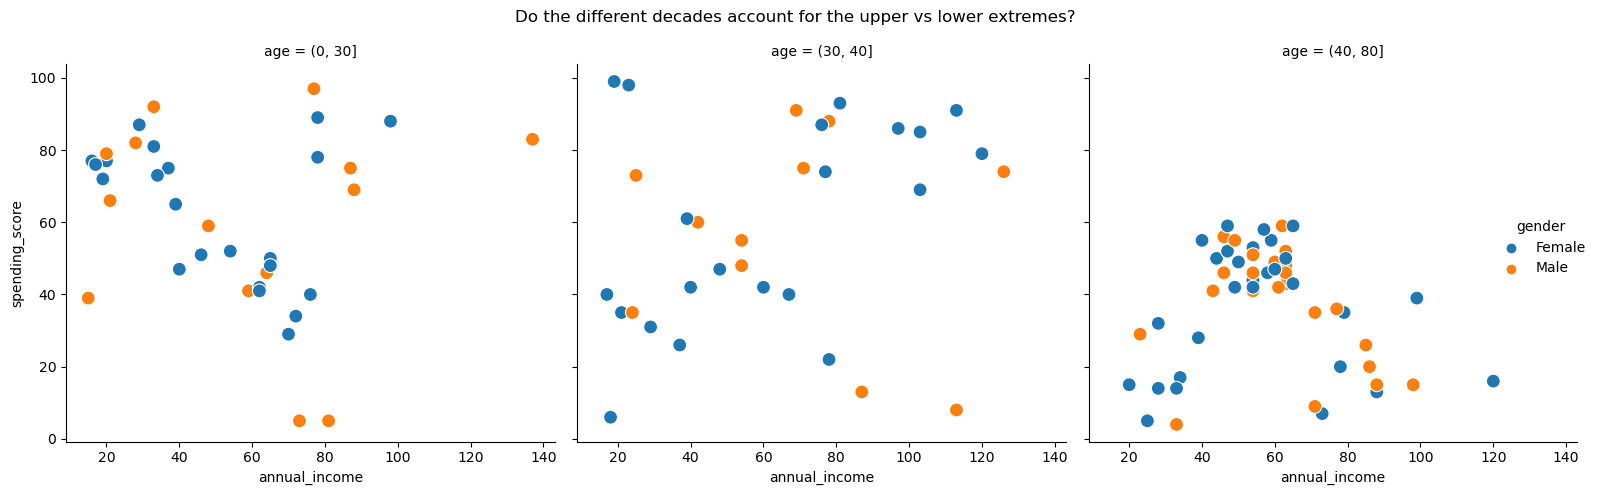

In [47]:
#visualize my plots
sns.relplot(data=train, 
            x='annual_income', 
            y='spending_score', 
            hue='gender',
            s=100,
            col=pd.cut(train.age,[0,30,40,80])
           )

plt.suptitle("Do the different decades account for the upper vs lower extremes?")
plt.tight_layout()
plt.show()

**Takeaways:**
- in our over 40 group, it looks like females are making less than males
- age over 40, middle income spend more
- didnt see any other gender trends
- overall, people over 40 spend the least

## Q. If we control for annual income, does spending score differ across age?

Since I want to control for annual income, I need to bin it.

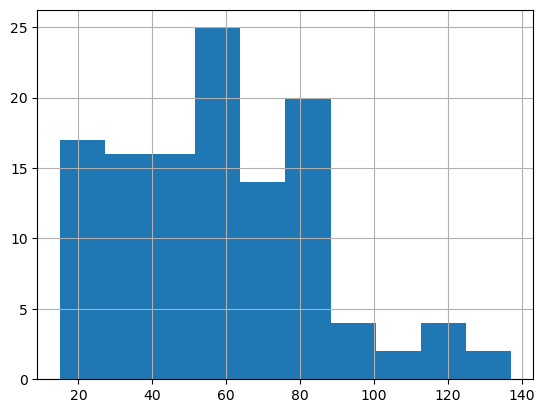

In [48]:
#look at it to figure out some bins
train.annual_income.hist()
plt.show()

In [54]:
#make the bins
train['income_bins'] = pd.cut(train.annual_income, [0,70,140])
train.head()

,gender,age,annual_income,spending_score,is_male,age_scaled,annual_income_scaled,age_bins,income_bins
customer_id,,,,,,,,,
158,Female,30,78,78,0,0.230769,0.516393,40_and_under,"(70, 140]"
14,Female,24,20,77,0,0.115385,0.040984,40_and_under,"(0, 70]"
116,Female,19,65,50,0,0.019231,0.409836,40_and_under,"(0, 70]"
69,Male,19,48,59,1,0.019231,0.270492,40_and_under,"(0, 70]"
167,Male,42,86,20,1,0.461538,0.581967,over_40,"(70, 140]"


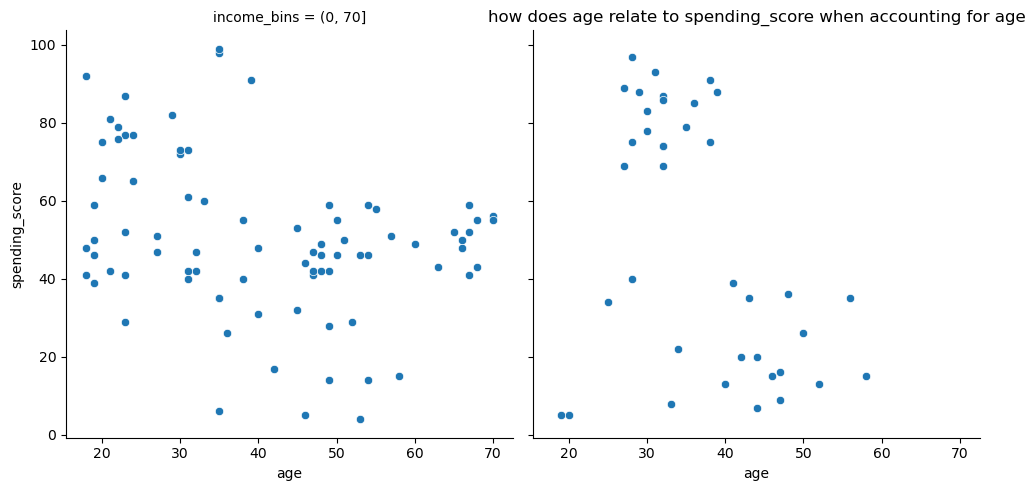

In [55]:
#visualize my variables
sns.relplot(data=train, 
            x='age', 
            y='spending_score',
            # hue='income_bins'
            col='income_bins'
           )

plt.title('how does age relate to spending_score when accounting for age')
plt.show()

**Takeaways:**
- no clear trends when controlling for income

## Explore Conclusion


- we saw age was important (especially over 40)
- gender overall didn't seem to do much, but saw changes in over 40
- saw potential for clusters
- saw some areas more bins like annual_income